In [2]:
import os
import re
import functools
import numpy as np
import pandas as pd
import pickle5 as pickle

In [3]:
# CURR_PATH = os.getcwd()
CURR_PATH = '/home/svetlanamaslenkova/Documents/AKI_deep/LSTM'
DATA_PATH = '/home/svetlanamaslenkova/Documents/data/physionet.org/files/mimiciv/2.0/'
DF_PATH = CURR_PATH +'/dataframes_2/'
# ED_PATH = DATA_PATH+'physionet.org/files/mimic-iv-ed/1.0/ed/'
PKL_PATH = CURR_PATH+'/pickles_2/'
ICU_PATH = DATA_PATH + 'icu/'
HOSP_PATH = DATA_PATH + 'hosp/'

# Loading data

## Loading MIMIC IV tables

### hosp

patients

In [4]:
import pandas as pd

data_patients = pd.read_csv(HOSP_PATH+'patients.csv')

data_patients.columns = data_patients.columns.str.lower()

data_patients.head(5)

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000068,F,19,2160,2008 - 2010,NaN
3,10000084,M,72,2160,2017 - 2019,2161-02-13
4,10000102,F,27,2136,2008 - 2010,NaN


admissions

In [5]:
import pandas as pd

data_admissions = pd.read_csv(HOSP_PATH+'admissions.csv')

data_admissions.columns = data_admissions.columns.str.lower()

data_admissions.head(2)

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0


In [91]:
data_admissions['hadm_id'] = data_admissions['hadm_id'].astype(int)
# change charttime column to datettime type
format_ = '%Y-%m-%d %H:%M:%S'
# data_vitals['charttime'] = pd.to_datetime(data_vitals['charttime'], format=format_)
data_admissions['admittime'] = pd.to_datetime(data_admissions['admittime'], format=format_)
data_admissions['dischtime'] = pd.to_datetime(data_admissions['dischtime'], format=format_)

In [92]:
data_admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454324 entries, 0 to 454323
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   subject_id            454324 non-null  int64         
 1   hadm_id               454324 non-null  int64         
 2   admittime             454324 non-null  datetime64[ns]
 3   dischtime             454324 non-null  datetime64[ns]
 4   deathtime             9087 non-null    object        
 5   admission_type        454324 non-null  object        
 6   admission_location    454324 non-null  object        
 7   discharge_location    328519 non-null  object        
 8   insurance             454324 non-null  object        
 9   language              454324 non-null  object        
 10  marital_status        444608 non-null  object        
 11  race                  454324 non-null  object        
 12  edregtime             315460 non-null  object        
 13 

omr

In [233]:
import pandas as pd

data_omr = pd.read_csv(HOSP_PATH+'omr.csv')
data_omr.columns = data_omr.columns.str.lower()
format_ = '%Y-%m-%d %H:%M:%S'
data_omr['chartdate'] = pd.to_datetime(data_omr['chartdate'], format=format_)
print(data_omr.shape)
data_omr.head(5)

(6770301, 5)


,subject_id,chartdate,seq_num,result_name,result_value
0,10000032,2180-04-27,1,Blood Pressure,110/65
1,10000032,2180-04-27,1,Weight (Lbs),94
2,10000032,2180-05-07,1,BMI (kg/m2),18.0
3,10000032,2180-05-07,1,Height (Inches),60
4,10000032,2180-05-07,1,Weight (Lbs),92.15


In [234]:
data_omr.result_name.unique()

array(['Blood Pressure', 'Weight (Lbs)', 'BMI (kg/m2)', 'Height (Inches)',
       'Blood Pressure Sitting', 'Blood Pressure Standing (1 min)',
       'Blood Pressure Lying', 'Blood Pressure Standing (3 mins)', 'BMI',
       'Weight', 'Blood Pressure Standing', 'eGFR', 'Height'],
      dtype=object)

weight_data

In [339]:
weight_data = data_omr[data_omr.result_name.isin(['Weight', 'Weight (Lbs)'])]
weight_data['result_value'] = weight_data['result_value'].astype(float)

weight_data['weight_kg'] = [np.round(v * 0.45359237) for v in weight_data.loc[:, 'result_value']]
weight_data = data_icustays[['subject_id']].merge(weight_data[['subject_id', 'chartdate', 'weight_kg']]).drop_duplicates()

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [340]:
weight_data.describe()

,subject_id,weight_kg
count,5.200700e+05,5.200700e+05
mean,1.497994e+07,2.657037e+02
std,2.890909e+06,1.322370e+05
min,1.000003e+07,0.000000e+00
25%,1.245734e+07,6.500000e+01
50%,1.499547e+07,7.800000e+01
75%,1.750766e+07,9.300000e+01
max,1.999983e+07,9.536224e+07


In [344]:
# remove outliers (incorectly documented weight) 
weight_data = weight_data[~(weight_data.weight_kg>250)]

In [345]:
print(weight_data.shape)
weight_data.head(5)

(519936, 3)


,subject_id,chartdate,weight_kg
0,10000032,2180-04-27,43.0
1,10000032,2180-05-07,42.0
18,10000032,2180-05-25,43.0
19,10000032,2180-06-01,43.0
20,10000032,2180-06-22,44.0


In [349]:
# get the most recent to icu stay weight of patients 
weight_data_icu = data_icustays[['subject_id', 'hadm_id',	'stay_id', 'intime', 'outtime']].merge(weight_data)
weight_data_icu = weight_data_icu[(weight_data_icu.chartdate > weight_data_icu.intime - pd.Timedelta(180, 'd'))&(weight_data_icu.chartdate < weight_data_icu.outtime)]\
                                    .sort_values('weight_kg', ascending=False).drop_duplicates('hadm_id', keep='last').drop(columns=['intime', 'outtime', 'chartdate'])
print(weight_data_icu.hadm_id.unique().shape[0])
weight_data_icu.head()

29730


,subject_id,hadm_id,stay_id,weight_kg
672218,16544239,20374585,39612415,242.0
939894,19319058,21528770,36568607,240.0
994738,19859524,20462426,36936105,230.0
733104,17223574,22760025,30532955,228.0
733090,17223574,22658769,31115966,228.0


In [381]:
with open(PKL_PATH + 'weight_data_icu.pkl', 'wb') as f:
    pickle.dump(weight_data_icu, f, protocol=pickle.HIGHEST_PROTOCOL)

In [382]:
with open(PKL_PATH + 'weight_data_icu.pkl', 'rb') as f:
    weight_data_icu = pickle.load(f)

d_icd_diagnoses

In [263]:
import pandas as pd

data_d_icd_diagnoses = pd.read_csv(HOSP_PATH+'d_icd_diagnoses.csv')

data_d_icd_diagnoses.columns = data_d_icd_diagnoses.columns.str.lower()

data_d_icd_diagnoses.head()

,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor
2,0019,9,"Cholera, unspecified"
3,0020,9,Typhoid fever
4,0021,9,Paratyphoid fever A


diagnoses_icd

In [265]:
import pandas as pd

data_diagnoses = pd.read_csv(HOSP_PATH+'diagnoses_icd.csv')

data_diagnoses.columns = data_diagnoses.columns.str.lower()

data_diagnoses.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


labitems

In [9]:
import pandas as pd

data_labitems = pd.read_csv(HOSP_PATH+'d_labitems.csv')

data_labitems.columns = data_labitems.columns.str.lower()
data_labitems.label = data_labitems.label.str.lower()
labitems = data_labitems.copy()
data_labitems.head(2)

,itemid,label,fluid,category
0,50801,alveolar-arterial gradient,Blood,Blood Gas
1,50802,base excess,Blood,Blood Gas


labevents

In [10]:
# take item ids of all needed features
creatinine_id = labitems[labitems.label.str.contains('creatinine').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
creatinine_serum_id = labitems[labitems.label.str.contains('creatinine, serum').fillna(False)].itemid.to_list()
urine_volume_id = labitems[labitems.label.str.contains('urine volume').fillna(False)].itemid.to_list()
anion_gap_id = labitems[labitems.label.str.contains('anion').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
albumin_id = labitems[labitems.label.str.contains('albumin').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
bands_id = labitems[labitems.label.str.contains('bands').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
bilirubin_id = labitems[labitems.label.str.contains('bilirubin').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
hematocrit_id = labitems[labitems.label.str.contains('hematocrit').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
lactate_id = labitems[labitems.label.str.contains('lactate').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
sodium_id = labitems[labitems.label.str.contains('sodium').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
bicarbonate_id = labitems[labitems.label.str.contains('bicarbonate').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
bun_id = labitems[labitems.label.str.contains('nitrogen').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
calcium_id = labitems[labitems.label.str.contains('calcium').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
chloride_id = labitems[labitems.label.str.contains('chloride').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
hemoglobin_id = list(set(labitems[labitems.label.str.contains('hemoglobin').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()) - set(['51212']))
inr_id = labitems[labitems.label.str.contains('inr').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
platelet_id = labitems[labitems.label.str.contains('platelet').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
potassium_id = labitems[labitems.label.str.contains('potassium').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
pt_id = ['51274', '52921', '52163', '52164']
ppt_id = ['51275', '52923', '52165', '52166', '52166', '52167']
wbc_id = labitems[labitems.label.str.contains('wbc').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()
glucose_id = labitems[labitems.label.str.contains('glucose').fillna(False) & labitems.fluid.isin(['Blood', 'Urine'])].itemid.to_list()

In [142]:
lab_itemids = [*creatinine_id, *creatinine_serum_id, *urine_volume_id, *anion_gap_id, *albumin_id, *bands_id, *bilirubin_id, *hematocrit_id, *lactate_id,\
    *sodium_id, *bicarbonate_id, *bun_id, *calcium_id, *chloride_id, *hemoglobin_id, *inr_id, *platelet_id, *potassium_id, *pt_id, *ppt_id, *wbc_id, *glucose_id]
# all needed itemids    
len(set(lab_itemids))

136

In [144]:
%%time
my_chunk = 1000000

# create the iterator
iter_csv = pd.read_csv(HOSP_PATH+'labevents.csv', 
        header=0, usecols=['subject_id', 'hadm_id', 'specimen_id', 'itemid','flag', 'charttime', 'valuenum', 'valueuom'],
                            dtype={'subject_id':'uint32', 'flag':'str', 'valueuom':'category'},
                       engine='c', keep_default_na=False,  skip_blank_lines=True, low_memory=False, iterator=True, chunksize=my_chunk)

# concatenate according to a filter to our result dataframe
df_result_lab = pd.concat(
    [chunk[chunk.itemid.isin(lab_itemids)] 
    for chunk in iter_csv])

CPU times: user 2min 23s, sys: 43.4 s, total: 3min 6s
Wall time: 3min 11s


In [145]:
labevents = df_result_lab.copy()
labevents = labevents.merge(data_labitems[['itemid', 'label', 'fluid', 'category']])

In [146]:
labevents['hadm_id'] = pd.to_numeric(labevents['hadm_id'], errors='coerce')
labevents['hadm_id'] = labevents['hadm_id'].fillna(0).astype(int)

# change charttime column to datettime type
format_ = '%Y-%m-%d %H:%M:%S'
labevents['charttime'] = pd.to_datetime(labevents['charttime'], format=format_)

# removing duplicated rows and rows with no valuenum
labevents = labevents.drop_duplicates()
labevents = labevents[~labevents.valuenum.isna()]

labevents = labevents[~labevents['valuenum'].str.contains("[a-zA-Z]+$")]
labevents['valuenum'] = pd.to_numeric(labevents['valuenum'], errors='coerce')
labevents = labevents.dropna(subset=['valuenum'])

labevents.flag = labevents.flag.astype(str)

labevents.shape

(45761980, 11)

In [95]:
labevents = labevents.merge(data_admissions[['subject_id',	'hadm_id', 'admittime', 'dischtime']])

In [96]:
labevents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27386285 entries, 0 to 27386284
Data columns (total 13 columns):
 #   Column       Dtype         
---  ------       -----         
 0   subject_id   uint32        
 1   hadm_id      int64         
 2   specimen_id  int64         
 3   itemid       int64         
 4   charttime    datetime64[ns]
 5   valuenum     float64       
 6   valueuom     object        
 7   flag         object        
 8   label        object        
 9   fluid        object        
 10  category     object        
 11  admittime    datetime64[ns]
 12  dischtime    datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(3), object(5), uint32(1)
memory usage: 2.8+ GB


In [99]:
with open(PKL_PATH + 'labevents.pkl', 'wb') as f:
    pickle.dump(labevents, f, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
with open(PKL_PATH + 'labevents.pkl', 'rb') as f:
    labevents = pickle.load(f)

labevents createnine

In [134]:
creatinine_blood_id = [50912, 52546]
labevents_creatinine = labevents[labevents.itemid.isin(creatinine_blood_id)]

In [135]:
labevents_creatinine['day_id'] = labevents_creatinine['charttime'] - labevents_creatinine['admittime']
labevents_creatinine['day_id'] = [d.days for d in labevents_creatinine.loc[:, 'day_id']]

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [143]:
labevents_creatinine['_12h_window_id'] = labevents_creatinine['charttime'] - labevents_creatinine['admittime']
labevents_creatinine['_12h_window_id'] = [(d.days*24 + d.seconds//3600)//12 for d in labevents_creatinine.loc[:, '_12h_window_id']]

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [139]:
labevents_creatinine['hour_id'] = labevents_creatinine['charttime'] - labevents_creatinine['admittime']
labevents_creatinine['hour_id'] = [(d.days*24 + d.seconds//3600) for d in labevents_creatinine.loc[:, 'hour_id']]

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [149]:
labevents_creatinine.sort_values(['hadm_id', 'charttime']).head()

,subject_id,hadm_id,specimen_id,itemid,charttime,valuenum,valueuom,flag,label,fluid,category,admittime,dischtime,day_id,_12h_window_id,hour_id
24562770,10467237,20000019,93881570,50912,2159-03-21 06:45:00,1.1,mg/dL,,creatinine,Blood,Chemistry,2159-03-20 21:08:00,2159-03-23 16:54:00,0,0,9
24562771,10467237,20000019,41011011,50912,2159-03-22 06:05:00,1.2,mg/dL,abnormal,creatinine,Blood,Chemistry,2159-03-20 21:08:00,2159-03-23 16:54:00,1,2,32
24562772,10467237,20000019,47569077,50912,2159-03-23 07:15:00,0.9,mg/dL,,creatinine,Blood,Chemistry,2159-03-20 21:08:00,2159-03-23 16:54:00,2,4,58
16274255,16925328,20000024,96139734,50912,2151-05-26 07:35:00,1.1,mg/dL,,creatinine,Blood,Chemistry,2151-05-25 21:44:00,2151-05-26 18:36:00,0,0,9
22101948,19430048,20000034,889934,50912,2174-05-23 07:35:00,2.3,mg/dL,abnormal,creatinine,Blood,Chemistry,2174-05-22 19:13:00,2174-05-24 17:27:00,0,1,12


In [150]:
with open(PKL_PATH + 'labevents_creatinine.pkl', 'wb') as f:
    pickle.dump(labevents_creatinine, f, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
with open(PKL_PATH + 'labevents_creatinine.pkl', 'rb') as f:
    labevents_creatinine = pickle.load(f)

prescriptions

In [158]:
import pandas as pd

data_prescriptions = pd.read_csv(HOSP_PATH+'prescriptions.csv')

data_prescriptions.columns = data_prescriptions.columns.str.lower()

# data_prescriptions['ndc'] = data_prescriptions['ndc'].astype('uint64')

data_prescriptions.head(5)

/home/svetlanamaslenkova/anaconda_envs/aki_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,subject_id,hadm_id,pharmacy_id,poe_id,poe_seq,starttime,stoptime,drug_type,drug,formulary_drug_cd,gsn,ndc,prod_strength,form_rx,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,doses_per_24_hrs,route
0,10000032,22595853,11700683,10000032-34,34.0,2180-05-07 01:00:00,2180-05-07 22:00:00,MAIN,Acetaminophen,APAP500,004490,9.041989e+08,500mg Tablet,NaN,500,mg,1,TAB,NaN,PO/NG
1,10000032,22595853,14779570,10000032-22,22.0,2180-05-07 00:00:00,2180-05-07 22:00:00,MAIN,Sodium Chloride 0.9% Flush,NACLFLUSH,NaN,0.000000e+00,10 mL Syringe,NaN,3,mL,0.3,SYR,3.0,IV
2,10000032,22595853,19796602,10000032-50,50.0,2180-05-08 08:00:00,2180-05-07 22:00:00,MAIN,Furosemide,FURO40,008209,5.107901e+10,40mg Tablet,NaN,40,mg,1,TAB,1.0,PO/NG
3,10000032,22595853,20256254,10000032-32,32.0,2180-05-07 01:00:00,2180-05-07 22:00:00,MAIN,Raltegravir,RALT400,063231,6.022761e+06,400 mg Tablet,NaN,400,mg,1,TAB,2.0,PO
4,10000032,22595853,28781051,10000032-27,27.0,2180-05-07 00:00:00,2180-05-07 22:00:00,MAIN,Heparin,HEPA5I,006549,6.332303e+10,5000 Units / mL- 1mL Vial,NaN,5000,UNIT,1,mL,3.0,SC


### ICU

d_items

In [14]:
import pandas as pd

data_d_items = pd.read_csv(ICU_PATH + 'd_items.csv')

data_d_items.columns = data_d_items.columns.str.lower()

data_d_items.head()

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220001,Problem List,Problem List,chartevents,General,NaN,Text,NaN,NaN
1,220003,ICU Admission date,ICU Admission date,datetimeevents,ADT,NaN,Date and time,NaN,NaN
2,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN
3,220046,Heart rate Alarm - High,HR Alarm - High,chartevents,Alarms,bpm,Numeric,NaN,NaN
4,220047,Heart Rate Alarm - Low,HR Alarm - Low,chartevents,Alarms,bpm,Numeric,NaN,NaN


In [15]:
for _, row in  data_d_items.iterrows():
    print(row.itemid, '|', row.label, '|', row.category)

220001 | Problem List | General
220003 | ICU Admission date | ADT
220045 | Heart Rate | Routine Vital Signs
220046 | Heart rate Alarm - High | Alarms
220047 | Heart Rate Alarm - Low | Alarms
220048 | Heart Rhythm | Routine Vital Signs
220050 | Arterial Blood Pressure systolic | Routine Vital Signs
220051 | Arterial Blood Pressure diastolic | Routine Vital Signs
220052 | Arterial Blood Pressure mean | Routine Vital Signs
220056 | Arterial Blood Pressure Alarm - Low | Alarms
220058 | Arterial Blood Pressure Alarm - High | Alarms
220059 | Pulmonary Artery Pressure systolic | Hemodynamics
220060 | Pulmonary Artery Pressure diastolic | Hemodynamics
220061 | Pulmonary Artery Pressure mean | Hemodynamics
220063 | Pulmonary Artery Pressure Alarm - High | Alarms
220066 | Pulmonary Artery Pressure Alarm - Low | Alarms
220069 | Left Artrial Pressure | Hemodynamics
220072 | Central Venous Pressure Alarm - High | Alarms
220073 | Central Venous Pressure  Alarm - Low | Alarms
220074 | Central Venous 

chartevents

In [18]:
chart_items_vitals = [225309, 225312, 226329, 220048, 225310, 224192, 228640, 220179, 223762, 227243, 220181, 224643, 224167, 220052, 220051, 220050, 220180,
                        227242, 223761, 223765, 223766, 224645, 224646, 224647, 226092, 220045, 224359, 227016, 227015, 220046, 220047, 227858, 227916, 223764,
                        223765, 224647]
len(set(chart_items_vitals))

34

In [19]:
%%time
import pandas as pd

my_chunk = 1000000

# create the iterator
iter_csv = pd.read_csv(ICU_PATH + 'chartevents.csv', header=0, usecols=['subject_id', 'hadm_id', 'stay_id', 'charttime', 'itemid', 'value', 'valuenum', 'valueuom'], \
                        dtype={'subject_id':'uint32', 'hadm_id':'uint32', 'stay_id':'uint32', 'valueuom':'category'},\
                            engine='c', keep_default_na=False, skip_blank_lines=True, low_memory=False, iterator=True, chunksize=my_chunk )              

# concatenate according to a filter to our result dataframe
df_result = pd.concat(\
    [chunk[chunk.itemid.isin(chart_items_vitals)] 
    for chunk in iter_csv])
         

CPU times: user 4min 56s, sys: 53.8 s, total: 5min 50s
Wall time: 5min 50s


In [20]:
data_chartevents = df_result.copy()
data_chartevents = data_chartevents.merge(data_d_items[['itemid', 'label', 'abbreviation', 'category', 'unitname', 'param_type']])
data_chartevents.columns = data_chartevents.columns.str.lower()

print('unique stays: ', data_chartevents.stay_id.unique().shape)
data_chartevents.head()

unique stays:  (76924,)


,subject_id,hadm_id,stay_id,charttime,itemid,value,valuenum,valueuom,label,abbreviation,category,unitname,param_type
0,10000032,29079034,39553978,2180-07-23 14:00:00,220048,SR (Sinus Rhythm),,,Heart Rhythm,Heart Rhythm,Routine Vital Signs,NaN,Text
1,10000032,29079034,39553978,2180-07-23 14:30:00,220048,SR (Sinus Rhythm),,,Heart Rhythm,Heart Rhythm,Routine Vital Signs,NaN,Text
2,10000032,29079034,39553978,2180-07-23 15:00:00,220048,SR (Sinus Rhythm),,,Heart Rhythm,Heart Rhythm,Routine Vital Signs,NaN,Text
3,10000032,29079034,39553978,2180-07-23 16:00:00,220048,ST (Sinus Tachycardia),,,Heart Rhythm,Heart Rhythm,Routine Vital Signs,NaN,Text
4,10000032,29079034,39553978,2180-07-23 17:00:00,220048,SR (Sinus Rhythm),,,Heart Rhythm,Heart Rhythm,Routine Vital Signs,NaN,Text


In [21]:
# remove lab events from the table, because they are in labevents already 
data_chartevents_nl = data_chartevents[~data_chartevents.category.str.contains('Labs')]

In [22]:
# create dataframe with unique item ids
unique_chart_items = data_chartevents_nl.drop_duplicates(subset=['itemid'])

In [23]:
# print items
print('itemid | label | category | valuenum')
for _, row in  unique_chart_items.sort_values('category').iterrows():
    print(row.itemid, '|', row.label, '|', row.category, '|', row.value)

itemid | label | category | value
220046 | Heart rate Alarm - High | Alarms | 120
220047 | Heart Rate Alarm - Low | Alarms | 60
227858 | Rest HR - Aerobic Capacity | OT Notes | 88
227916 | Rest HR -  Aerobic Activity Response | OT Notes | 102
227242 | Manual Blood Pressure Diastolic Right | Routine Vital Signs | 67
227243 | Manual Blood Pressure Systolic Right | Routine Vital Signs | 99
224192 | Pulsus Paradoxus | Routine Vital Signs | 12
224359 | QTc | Routine Vital Signs | 0.47
223764 | Orthostatic HR lying | Routine Vital Signs | 88
220048 | Heart Rhythm | Routine Vital Signs | SR (Sinus Rhythm)
226329 | Blood Temperature CCO (C) | Routine Vital Signs | 36.4
226092 | Orthostatic BPd lying | Routine Vital Signs | 65
224646 | Orthostatic BPs sitting | Routine Vital Signs | 96
223766 | Orthostatic BPs standing | Routine Vital Signs | 91
224647 | Orthostatic HR standing | Routine Vital Signs | 91
223765 | Orthostatic HR sitting | Routine Vital Signs | 92
224645 | Orthostatic BPs lying |

In [24]:
chartevents_vitals = data_chartevents_nl[data_chartevents_nl.itemid.isin(chart_items_vitals)]
print(chartevents_vitals.shape)

(37149104, 13)


In [25]:
with open(PKL_PATH + 'chartevents_vitals.pkl', 'wb') as f:
    pickle.dump(chartevents_vitals, f, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
with open(PKL_PATH + 'chartevents_vitals.pkl', 'rb') as f:
    chartevents_vitals = pickle.load(f)

data_datetimeevents

In [5]:
import pandas as pd

data_datetimeevents = pd.read_csv(ICU_PATH + 'datetimeevents.csv')

data_datetimeevents.columns = data_datetimeevents.columns.str.lower()

data_datetimeevents.head()

,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valueuom,warning
0,10003700,28623837,30600691,2165-04-24 05:42:00,2165-04-24 05:42:00,225755,2165-04-24 05:42:00,Date,0
1,10003700,28623837,30600691,2165-04-24 08:00:00,2165-04-24 08:26:00,225755,2165-04-24 00:00:00,Date,0
2,10004235,24181354,34100191,2196-02-24 18:06:00,2196-02-24 18:07:00,224261,2196-02-24 18:06:00,Date,0
3,10004235,24181354,34100191,2196-02-24 18:06:00,2196-02-24 18:07:00,224279,2196-02-24 18:06:00,Date and Time,0
4,10004235,24181354,34100191,2196-02-24 18:06:00,2196-02-24 18:07:00,224280,2196-02-24 18:06:00,Date,0


icustays

In [27]:
import pandas as pd

data_icustays = pd.read_csv(ICU_PATH + 'icustays.csv')

data_icustays.columns = data_icustays.columns.str.lower()

data_icustays.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266
1,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535
2,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032
3,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113
4,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588


In [ ]:
data_icustays['hadm_id'] = data_icustays['hadm_id'].astype(int)
# change charttime column to datettime type
format_ = '%Y-%m-%d %H:%M:%S'
data_icustays['intime'] = pd.to_datetime(data_icustays['intime'], format=format_)
data_icustays['outtime'] = pd.to_datetime(data_icustays['outtime'], format=format_)

In [169]:
print('n of unique patients: ', (data_icustays.subject_id.unique().shape[0]))
print('n of unique admissions: ', (data_icustays.hadm_id.unique().shape[0]))
print('n of unique ICU stays: : ', (data_icustays.stay_id.unique().shape[0]))

n of unique patients:  53569
n of unique admissions:  69639
n of unique ICU stays: :  76943


In [179]:
S = data_icustays.merge(data_admissions[['subject_id', 'hadm_id', 'admittime']], how='left')
S['day_id'] = S['intime'] - S['admittime']
S['day_id'] = [d.days for d in S.loc[:, 'day_id']]
S

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,admittime,day_id
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,2180-07-23 12:35:00,0
1,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535,2189-06-27 07:38:00,0
2,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,2157-11-18 22:56:00,1
3,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113,2157-12-18 16:58:00,0
4,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588,2110-04-11 15:08:00,0
...,...,...,...,...,...,...,...,...,...,...
76938,19999442,26785317,32336619,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2148-11-19 14:23:43,2148-11-26 13:12:15,6.950370,2148-11-19 10:00:00,0
76939,19999625,25304202,31070865,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2139-10-10 19:18:00,2139-10-11 18:21:28,0.960741,2139-10-10 18:06:00,0
76940,19999828,25744818,36075953,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995,2149-01-08 16:44:00,0
76941,19999840,21033226,38978960,Trauma SICU (TSICU),Surgical Intensive Care Unit (SICU),2164-09-12 09:26:28,2164-09-17 16:35:15,5.297766,2164-09-10 13:47:00,1


inputevents

In [28]:
import pandas as pd

data_inputevents = pd.read_csv(ICU_PATH + 'inputevents.csv')

data_inputevents.columns = data_inputevents.columns.str.lower()

data_inputevents.head().iloc[:, :14]

,subject_id,hadm_id,stay_id,starttime,endtime,storetime,itemid,amount,amountuom,rate,rateuom,orderid,linkorderid,ordercategoryname
0,10000032,29079034,39553978,2180-07-23 17:00:00,2180-07-23 17:01:00,2180-07-23 18:56:00,226452,200.000000,ml,NaN,NaN,7140773,7140773,14-Oral/Gastric Intake
1,10000032,29079034,39553978,2180-07-23 17:00:00,2180-07-23 17:30:00,2180-07-23 17:02:00,220862,49.999999,ml,100.0,mL/hour,7578214,7578214,04-Fluids (Colloids)
2,10000032,29079034,39553978,2180-07-23 17:33:00,2180-07-23 18:03:00,2180-07-23 18:16:00,220862,49.999999,ml,100.0,mL/hour,427849,427849,04-Fluids (Colloids)
3,10000032,29079034,39553978,2180-07-23 18:56:00,2180-07-23 18:57:00,2180-07-23 18:56:00,226452,100.000000,ml,NaN,NaN,1579487,1579487,14-Oral/Gastric Intake
4,10000032,29079034,39553978,2180-07-23 21:10:00,2180-07-23 21:11:00,2180-07-23 21:10:00,226452,100.000000,ml,NaN,NaN,415918,415918,14-Oral/Gastric Intake


In [29]:
data_inputevents.head().iloc[:, 14:]

,secondaryordercategoryname,ordercomponenttypedescription,ordercategorydescription,patientweight,totalamount,totalamountuom,isopenbag,continueinnextdept,statusdescription,originalamount,originalrate
0,NaN,Main order parameter,Bolus,39.4,200.0,ml,0,0,FinishedRunning,200.0,200.0
1,NaN,Main order parameter,Continuous IV,39.4,50.0,ml,0,0,FinishedRunning,50.0,100.0
2,NaN,Main order parameter,Continuous IV,39.4,50.0,ml,0,0,FinishedRunning,50.0,100.0
3,NaN,Main order parameter,Bolus,39.4,100.0,ml,0,0,FinishedRunning,100.0,100.0
4,NaN,Main order parameter,Bolus,39.4,100.0,ml,0,0,FinishedRunning,100.0,100.0


outputevents

In [184]:
import pandas as pd

data_outputevents = pd.read_csv(ICU_PATH + 'outputevents.csv')

data_outputevents = data_outputevents.merge(data_d_items, on='itemid')

data_outputevents.columns = data_outputevents.columns.str.lower()
data_outputevents['hadm_id'] = data_outputevents['hadm_id'].astype(int)
# change charttime column to datettime type
format_ = '%Y-%m-%d %H:%M:%S'
data_outputevents['charttime'] = pd.to_datetime(data_outputevents['charttime'], format=format_)

data_outputevents.head()

,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valueuom,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,10000032,29079034,39553978,2180-07-23 15:00:00,2180-07-23 16:00:00,226560,175.0,ml,Void,Void,outputevents,Output,mL,Numeric,NaN,NaN
1,10001217,24597018,37067082,2157-11-20 19:00:00,2157-11-21 02:20:00,226560,100.0,ml,Void,Void,outputevents,Output,mL,Numeric,NaN,NaN
2,10001217,24597018,37067082,2157-11-20 22:00:00,2157-11-21 02:20:00,226560,120.0,ml,Void,Void,outputevents,Output,mL,Numeric,NaN,NaN
3,10001217,24597018,37067082,2157-11-21 00:42:00,2157-11-21 00:43:00,226560,300.0,ml,Void,Void,outputevents,Output,mL,Numeric,NaN,NaN
4,10001217,24597018,37067082,2157-11-21 04:00:00,2157-11-21 06:38:00,226560,600.0,ml,Void,Void,outputevents,Output,mL,Numeric,NaN,NaN


In [31]:
print('itemid | label | abbreviation | category')
for _, row in data_outputevents.drop_duplicates('itemid').iterrows():
    print(f'{row.itemid} | {row.label} |  {row.abbreviation} | {row.category}')

itemid | label | abbreviation | category
226560 | Void |  Void | Output
226559 | Foley |  Foley | Output
226633 | Pre-Admission |  Pre-Admission | Output
226571 | Emesis |  Emesis | Output
226576 | Oral Gastric |  Oral Gastric | Output
227510 | TF Residual |  TF Residual | Output
226627 | OR Urine |  OR Urine | Output
226588 | Chest Tube #1 |  Chest Tube #1 | Output
226589 | Chest Tube #2 |  Chest Tube #2 | Output
226626 | OR EBL |  OR EBL | Output
226583 | Rectal Tube |  Rectal Tube | Output
226579 | Stool |  Stool | Output
226580 | Fecal Bag |  Fecal Bag | Output
226619 | Pigtail #1 |  Pigtail #1 | Drains
226561 | Condom Cath |  Condom Cath | Output
227701 | Drainage Bag |  Drainage Bag | Drains
226632 | Cath Lab |  Cath Lab | Output
227488 | GU Irrigant Volume In |  GU Irrigant Volume In | Output
227489 | GU Irrigant/Urine Volume Out |  GU Irrigant/Urine Volume Out | Output
226575 | Nasogastric |  Nasogastric | Output
226599 | Jackson Pratt #1 |  Jackson Pratt #1 | Drains
226600 | J

In [185]:
data_outputevents = data_outputevents.merge(data_admissions[['subject_id',	'hadm_id', 'admittime']])

In [187]:
data_outputevents['day_id'] = data_outputevents['charttime'] - data_outputevents['admittime']
data_outputevents['day_id'] = [d.days for d in data_outputevents.loc[:, 'day_id']]

In [188]:
data_outputevents['_12h_window_id'] = data_outputevents['charttime'] - data_outputevents['admittime']
data_outputevents['_12h_window_id'] = [(d.days*24 + d.seconds//3600)//12 for d in data_outputevents.loc[:, '_12h_window_id']]

data_outputevents['hour_id'] = data_outputevents['charttime'] - data_outputevents['admittime']
data_outputevents['hour_id'] = [(d.days*24 + d.seconds//3600) for d in data_outputevents.loc[:, 'hour_id']]

In [196]:
data_outputevents.head(1)

,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valueuom,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue,admittime,day_id,_12h_window_id,hour_id
0,10000032,29079034,39553978,2180-07-23 15:00:00,2180-07-23 16:00:00,226560,175.0,ml,Void,Void,outputevents,Output,mL,Numeric,NaN,NaN,2180-07-23 12:35:00,0,0,2


procedureevents

In [10]:
import pandas as pd

data_procedureevents = pd.read_csv(ICU_PATH + 'procedureevents.csv')

data_procedureevents.columns = data_procedureevents.columns.str.lower()

data_procedureevents.head()

,subject_id,hadm_id,stay_id,starttime,endtime,storetime,itemid,value,valueuom,location,...,patientweight,totalamount,totalamountuom,isopenbag,continueinnextdept,cancelreason,statusdescription,comments_date,originalamount,originalrate
0,15693895,21203492,30500789,2147-06-05 11:25:00,2147-06-05 11:26:00,2147-06-06 11:25:00,225399,1.0,None,NaN,...,80.0,NaN,NaN,0,0,0,FinishedRunning,NaN,1.0,0
1,15693895,21203492,30500789,2147-06-05 22:00:00,2147-06-05 22:01:00,2147-06-06 11:25:00,224385,1.0,None,NaN,...,80.0,NaN,NaN,0,0,0,FinishedRunning,NaN,1.0,0
2,12481680,26876606,30863119,2141-01-23 12:00:00,2141-01-23 18:33:00,2141-01-23 18:33:51.14,224275,393.0,min,NaN,...,123.0,NaN,NaN,1,0,0,FinishedRunning,NaN,393.0,1
3,12481680,26876606,30863119,2141-01-23 12:00:00,2141-01-23 18:33:00,2141-01-23 18:33:51.14,224275,393.0,min,NaN,...,123.0,NaN,NaN,1,0,0,FinishedRunning,NaN,393.0,1
4,15614172,27424463,33484414,2153-07-29 18:13:00,2153-07-31 01:25:00,2153-07-31 01:26:00,224277,1872.0,min,RL Post Forearm,...,71.6,NaN,NaN,1,1,0,FinishedRunning,NaN,1872.0,1


## Loading prepared dataframes

In [33]:
with open('/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/pickles/' + 'pid_labevents.pkl', 'rb') as f:
    pid_labevents = pickle.load(f)
print('number of admissions from ICU: ', data_icustays[data_icustays.hadm_id.isin(pid_labevents.hadm_id.unique())].hadm_id.unique().shape[0])

number of admissions from ICU:  68465


In [34]:
with open('/home/svetlanamaslenkova/Documents/AKI_deep/LSTM/pickles/' + 'aki_status_df.pkl', 'rb') as f:
    final_aki_status = pickle.load(f)
final_aki_status = final_aki_status[~final_aki_status.isna()]
print('number of admissions from ICU: ', data_icustays[data_icustays.hadm_id.isin(final_aki_status.hadm_id.unique())].hadm_id.unique().shape[0])
final_aki_status.head()

number of admissions from ICU:  43545


,hadm_id,day_id,AKI_1,AKI_2,AKI_3
0,21476780,-1.0,0,0,0
1,21476780,0.0,0,0,0
2,20940957,0.0,0,0,0
3,20940957,1.0,0,0,0
4,20940957,2.0,0,0,0


In [32]:
with open(PKL_PATH + 'pid_vitals.pkl', 'rb') as f:
    pid_vitals = pickle.load(f)
temp = pid_vitals[pid_vitals.vitals.str.contains(r'[0-9]')]
print('number of admissions from ICU with any information: ', data_icustays[data_icustays.hadm_id.isin(temp.hadm_id.unique())].hadm_id.unique().shape[0])
print('number of admissions from ICU: ', data_icustays[data_icustays.hadm_id.isin(pid_vitals.hadm_id.unique())].hadm_id.unique().shape[0])
pid_vitals.head()

number of admissions from ICU with any information:  30843
number of admissions from ICU:  30843


,subject_id,hadm_id,day_id,vitals
0,10467237,20000019,-1,temp {99.1} heartrate {75.0} resprate {16.0} o...
1,10467237,20000019,0,temp {98.0} heartrate {65.0} resprate {16.0} o...
2,16925328,20000024,-1,temp {98.7} heartrate {72.0} resprate {16.0} o...
3,16925328,20000024,0,temp {98.2} heartrate {53.0} resprate {18.0} o...
4,11146739,20000057,-1,temp {99.3} heartrate {81.0} resprate {16.0} o...


In [33]:
with open(PKL_PATH + 'pid_medications.pkl', 'rb') as f:
    pid_medications = pickle.load(f)
temp = pid_medications[pid_medications.medications.str.contains(r'[a-zA-Z]')]
print('number of admissions from ICU with any information: ', data_icustays[data_icustays.hadm_id.isin(temp.hadm_id.unique())].hadm_id.unique().shape[0])
print('number of admissions from ICU: ', data_icustays[data_icustays.hadm_id.isin(pid_medications.hadm_id.unique())].hadm_id.unique().shape[0])
pid_medications.head()

number of admissions from ICU with any information:  69197
number of admissions from ICU:  69197


,subject_id,hadm_id,day_id,medications
0,17868682.0,22726960.0,-1.0,BuPROPion (Sustained Release) {300} mg ; BuPRO...
1,17868682.0,22726960.0,0.0,BuPROPion (Sustained Release) {300} mg ; BuPRO...
2,17868682.0,22726960.0,1.0,BuPROPion (Sustained Release) {150} mg ; Pneum...
3,17868682.0,25218370.0,0.0,Sodium Chloride 0.9% Flush {3} mL ; Lactated ...
4,17868682.0,25218370.0,1.0,Sodium Chloride 0.9% Flush {3} mL ; Acetamino...


In [34]:
with open(PKL_PATH + 'data_demographics.pkl', 'rb') as f:
    data_demographics = pickle.load(f)
temp = data_demographics[data_demographics.demographics.str.contains(r'M|F')]
print('number of admissions from ICU with any information: ', data_icustays[data_icustays.hadm_id.isin(temp.hadm_id.unique())].hadm_id.unique().shape[0])
print('number of admissions from ICU: ', data_icustays[data_icustays.hadm_id.isin(data_demographics.hadm_id.unique())].hadm_id.unique().shape[0])
data_demographics.head()

number of admissions from ICU with any information:  69211
number of admissions from ICU:  69211


,subject_id,hadm_id,admittime,dischtime,ethnicity,gender,age,demographics
43,10292548,26653546.0,2120-01-07 05:51:00,2120-01-12 13:45:00,ASIAN,F,35.0,ASIAN F 35.0
44,10292548,24067979.0,2119-07-26 04:35:00,2119-07-27 19:35:00,ASIAN,F,34.0,ASIAN F 34.0
56,19120008,24459786.0,2185-09-18 11:15:00,2185-09-20 15:30:00,ASIAN,M,70.0,ASIAN M 70.0
57,19120008,28496347.0,2187-07-27 01:04:00,2187-08-02 18:16:00,ASIAN,M,72.0,ASIAN M 72.0
58,19120008,27495024.0,2190-06-30 01:16:00,2190-07-18 18:07:00,ASIAN,M,75.0,ASIAN M 75.0


In [35]:
with open(PKL_PATH + 'hid_previous_diagnoses.pkl', 'rb') as f:
    df_previous_diags = pickle.load(f)
temp = df_previous_diags[df_previous_diags.previous_diags_icd.str.contains('D')]
print('number of admissions from ICU with any information: ', data_icustays[data_icustays.hadm_id.isin(temp.hadm_id.unique())].hadm_id.unique().shape[0])
print('number of admissions from ICU: ', data_icustays[data_icustays.hadm_id.isin(df_previous_diags.hadm_id.unique())].hadm_id.unique().shape[0])
df_previous_diags.head()

number of admissions from ICU with any information:  33723
number of admissions from ICU:  69179


,hadm_id,previous_diags_icd,previous_diags_titles
0,21081215,,
1,26733622,,
2,20302177,,
3,22079847,,
4,20383396,,


In [36]:
with open(PKL_PATH + 'labevents_creatinine.pkl', 'rb') as f:
    labevents_creatinine = pickle.load(f)
print('number of admissions from ICU: ', data_icustays[data_icustays.hadm_id.isin(labevents_creatinine.hadm_id.unique())].hadm_id.unique().shape[0])
labevents_creatinine.head()

number of admissions from ICU:  43607


,subject_id,hadm_id,charttime,value,valueuom,admittime,day_id
9,10003299,21476780,2183-02-26 22:18:00,1.1,mg/dL,2183-02-27 15:18:00,-1.0
10,10003299,21476780,2183-02-28 06:42:00,0.9,mg/dL,2183-02-27 15:18:00,0.0
11,10003299,20940957,2183-06-27 05:57:00,0.6,mg/dL,2183-06-26 20:27:00,0.0
12,10003299,20940957,2183-06-28 04:42:00,0.7,mg/dL,2183-06-26 20:27:00,1.0
13,10003299,20940957,2183-06-29 05:34:00,0.7,mg/dL,2183-06-26 20:27:00,2.0


# Data analysis

In [173]:
print('n of unique patients: ', (data_icustays.subject_id.unique().shape[0]))
print('n of unique admissions: ', (data_icustays.hadm_id.unique().shape[0]))
print('n of unique ICU stays: : ', (data_icustays.stay_id.unique().shape[0]))

n of unique patients:  53569
n of unique admissions:  69639
n of unique ICU stays: :  76943


In [37]:
# number of admissions with aki status available from ICU wards
icu_aki_status = final_aki_status.merge(data_icustays, on='hadm_id', how='inner')
print('number of admissions with aki status available from ICU wards: ', \
                    icu_aki_status.hadm_id.unique().shape[0])

print('number of admissions in icu: ', data_icustays.hadm_id.unique().shape[0])

print('admissions with AKI 1 in ICU: ', icu_aki_status[icu_aki_status.AKI_1==1].drop_duplicates(subset=['hadm_id']).shape[0])
print('admissions with AKI 1 and 2 in ICU: ', icu_aki_status[icu_aki_status.AKI_2==1].drop_duplicates(subset=['hadm_id']).shape[0])
print('admissions with AKI 1 and 2 and 3 in ICU: ', icu_aki_status[icu_aki_status.AKI_3==1].drop_duplicates(subset=['hadm_id']).shape[0])

number of admissions with aki status available from ICU wards:  43597
number of admissions in icu:  69211
admissions with AKI 1 in ICU:  14784
admissions with AKI 1 and 2 in ICU:  4300
admissions with AKI 1 and 2 and 3 in ICU:  1504


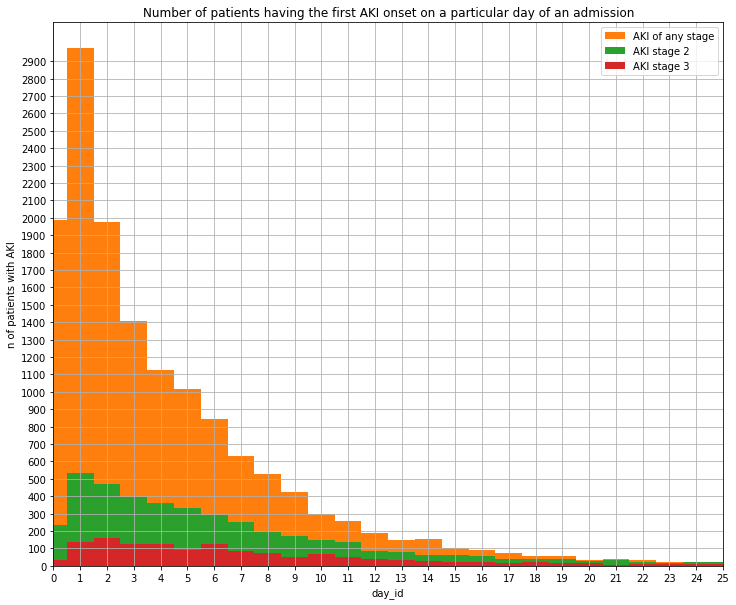

In [52]:
from cProfile import label
from matplotlib import pyplot as plt

g1 = icu_aki_status[icu_aki_status.AKI_1==1].sort_values(['hadm_id', 'day_id'])\
                        .drop_duplicates(['hadm_id'], keep='first')\
                            .groupby('day_id')\
                                .count()
index1 = g1.AKI_1.sort_values(ascending=False).index
values1 = g1.AKI_1.sort_values(ascending=False).values

g2 = icu_aki_status[icu_aki_status.AKI_2==1].sort_values(['hadm_id', 'day_id'])\
                        .drop_duplicates(['hadm_id'], keep='first')\
                            .groupby('day_id')\
                                .count()
index2 = g2.AKI_2.sort_values(ascending=False).index
values2 = g2.AKI_2.sort_values(ascending=False).values

g3 = icu_aki_status[icu_aki_status.AKI_3==1].sort_values(['hadm_id', 'day_id'])\
                        .drop_duplicates(['hadm_id'], keep='first')\
                            .groupby('day_id')\
                                .count()
index3 = g3.AKI_3.sort_values(ascending=False).index
values3 = g3.AKI_3.sort_values(ascending=False).values

fig, (ax2) = plt.subplots(1, 1, figsize=(12, 10), sharex=False) 

ax2.bar(index1, values1, width=1)
ax2.set_xticks(index1)
ax2.set_yticks(np.arange(0, 3000, 100))
ax2.set_xlim([0,25])
ax2.set_xlabel('day_id')
ax2.set_ylabel('n of patients with AKI')
ax2.bar(index1, values1, width=1, label='AKI of any stage')
ax2.bar(index2, values2, width=1, label='AKI stage 2')
ax2.bar(index3, values3, width=1, label='AKI stage 3')
ax2.set_title('Number of patients having the first AKI onset on a particular day of an admission')
ax2.grid(True)
ax2.legend()



# Calculate aki status for ICU patients

## Get urine output values

In [350]:
weight_data_icu.head(1)

,subject_id,hadm_id,stay_id,weight_kg
672218,16544239,20374585,39612415,242.0


In [44]:
print('itemid | label | value | valueuom | abbreviation | category')
for _, row in data_outputevents[data_outputevents.category=='Output'].drop_duplicates('itemid').iterrows():
    print(f'{row.itemid} | {row.label} | {row.value}  | {row.valueuom} | {row.abbreviation} | {row.category}')

itemid | label | value | valueuom | abbreviation | category
226560 | Void | 175.0  | ml | Void | Output
226559 | Foley | 450.0  | ml | Foley | Output
226633 | Pre-Admission | 400.0  | ml | Pre-Admission | Output
226571 | Emesis | 100.0  | ml | Emesis | Output
226576 | Oral Gastric | 10.0  | ml | Oral Gastric | Output
227510 | TF Residual | 0.0  | ml | TF Residual | Output
226627 | OR Urine | 450.0  | ml | OR Urine | Output
226588 | Chest Tube #1 | 5.0  | ml | Chest Tube #1 | Output
226589 | Chest Tube #2 | 1300.0  | ml | Chest Tube #2 | Output
226626 | OR EBL | 400.0  | ml | OR EBL | Output
226583 | Rectal Tube | 525.0  | ml | Rectal Tube | Output
226579 | Stool | 250.0  | ml | Stool | Output
226580 | Fecal Bag | 300.0  | ml | Fecal Bag | Output
226561 | Condom Cath | 300.0  | ml | Condom Cath | Output
226632 | Cath Lab | 150.0  | ml | Cath Lab | Output
227488 | GU Irrigant Volume In | 3000.0  | ml | GU Irrigant Volume In | Output
227489 | GU Irrigant/Urine Volume Out | 2800.0  | ml | 

In [59]:
urine_output_ids = [226559, 226627, 226561]

In [259]:
urine_output_df = data_outputevents[data_outputevents.itemid.isin(urine_output_ids)].sort_values(['subject_id',	'hadm_id',	'stay_id', 'charttime'])
urine_output_df['_6h_window_id'] = urine_output_df['charttime'] - urine_output_df['admittime']
urine_output_df['_6h_window_id'] = [(d.days*24 + d.seconds//3600)//6 for d in urine_output_df.loc[:, '_6h_window_id']]


In [379]:
urine_output_df[urine_output_df.stay_id==39765666]

,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valueuom,label,abbreviation,...,category,unitname,param_type,lownormalvalue,highnormalvalue,admittime,day_id,_12h_window_id,hour_id,_6h_window_id
1560871,10000980,26913865,39765666,2189-06-27 09:08:00,2189-06-27 09:08:00,226559,450.0,ml,Foley,Foley,...,Output,mL,Numeric,NaN,NaN,2189-06-27 07:38:00,0,0,1,0
1560872,10000980,26913865,39765666,2189-06-27 11:00:00,2189-06-27 10:51:00,226559,600.0,ml,Foley,Foley,...,Output,mL,Numeric,NaN,NaN,2189-06-27 07:38:00,0,0,3,0
1560873,10000980,26913865,39765666,2189-06-27 13:00:00,2189-06-27 12:55:00,226559,800.0,ml,Foley,Foley,...,Output,mL,Numeric,NaN,NaN,2189-06-27 07:38:00,0,0,5,0
1560874,10000980,26913865,39765666,2189-06-27 14:00:00,2189-06-27 14:12:00,226559,1000.0,ml,Foley,Foley,...,Output,mL,Numeric,NaN,NaN,2189-06-27 07:38:00,0,0,6,1
1560875,10000980,26913865,39765666,2189-06-27 15:00:00,2189-06-27 15:01:00,226559,400.0,ml,Foley,Foley,...,Output,mL,Numeric,NaN,NaN,2189-06-27 07:38:00,0,0,7,1
1560876,10000980,26913865,39765666,2189-06-27 16:00:00,2189-06-27 16:18:00,226559,300.0,ml,Foley,Foley,...,Output,mL,Numeric,NaN,NaN,2189-06-27 07:38:00,0,0,8,1
1560877,10000980,26913865,39765666,2189-06-27 17:00:00,2189-06-27 17:15:00,226559,350.0,ml,Foley,Foley,...,Output,mL,Numeric,NaN,NaN,2189-06-27 07:38:00,0,0,9,1


In [377]:
sum_urine_output_6h = urine_output_df[['subject_id', 'hadm_id',	'stay_id', '_6h_window_id', 'value']]\
                            .groupby(['subject_id', 'hadm_id', 'stay_id', '_6h_window_id'])\
                                .agg('sum').reset_index()\
                                    .merge(weight_data_icu)

sum_urine_output_12h = urine_output_df[['subject_id', 'hadm_id','stay_id', '_12h_window_id', 'value']]\
                            .groupby(['subject_id', 'hadm_id', 'stay_id', '_12h_window_id'])\
                                .agg('sum')\
                                    .reset_index().merge(weight_data_icu)
sum_urine_output_24h = urine_output_df[['subject_id', 'hadm_id','stay_id', 'day_id', 'value']]\
                            .groupby(['subject_id', 'hadm_id', 'stay_id', 'day_id'])\
                                .agg('sum')\
                                    .reset_index().merge(weight_data_icu)
sum_urine_output_6h

,subject_id,hadm_id,stay_id,_6h_window_id,value,weight_kg,urine_ml/kg/h
0,10000980,26913865,39765666,0,1850.0,75.0,4.111111
1,10000980,26913865,39765666,1,2050.0,75.0,4.555556
2,10001725,25563031,31205490,0,300.0,68.0,0.735294
3,10001725,25563031,31205490,1,445.0,68.0,1.090686
4,10001725,25563031,31205490,2,610.0,68.0,1.495098
...,...,...,...,...,...,...,...
256857,19999442,26785317,32336619,24,310.0,103.0,0.501618
256858,19999442,26785317,32336619,25,540.0,103.0,0.873786
256859,19999442,26785317,32336619,26,465.0,103.0,0.752427
256860,19999442,26785317,32336619,27,550.0,103.0,0.889968


In [378]:
sum_urine_output_6h['urine_ml/kg/h'] = sum_urine_output_6h['value'] / sum_urine_output_6h['weight_kg'] / 6
sum_urine_output_12h['urine_ml/kg/h'] = sum_urine_output_12h['value'] / sum_urine_output_12h['weight_kg'] / 12
sum_urine_output_24h['urine_ml/kg/h'] = sum_urine_output_24h['value'] / sum_urine_output_24h['weight_kg'] / 24

sum_urine_output_6h

,subject_id,hadm_id,stay_id,_6h_window_id,value,weight_kg,urine_ml/kg/h
0,10000980,26913865,39765666,0,1850.0,75.0,4.111111
1,10000980,26913865,39765666,1,2050.0,75.0,4.555556
2,10001725,25563031,31205490,0,300.0,68.0,0.735294
3,10001725,25563031,31205490,1,445.0,68.0,1.090686
4,10001725,25563031,31205490,2,610.0,68.0,1.495098
...,...,...,...,...,...,...,...
256857,19999442,26785317,32336619,24,310.0,103.0,0.501618
256858,19999442,26785317,32336619,25,540.0,103.0,0.873786
256859,19999442,26785317,32336619,26,465.0,103.0,0.752427
256860,19999442,26785317,32336619,27,550.0,103.0,0.889968


In [374]:
sum_urine_output_6h

,subject_id,hadm_id,stay_id,_6h_window_id,value,weight_kg,urine_ml/kg/h
0,10000980,26913865,39765666,0,1850.0,75.0,4.111111
1,10000980,26913865,39765666,1,2050.0,75.0,4.555556
2,10001725,25563031,31205490,0,300.0,68.0,0.735294
3,10001725,25563031,31205490,1,445.0,68.0,1.090686
4,10001725,25563031,31205490,2,610.0,68.0,1.495098
...,...,...,...,...,...,...,...
256857,19999442,26785317,32336619,24,310.0,103.0,0.501618
256858,19999442,26785317,32336619,25,540.0,103.0,0.873786
256859,19999442,26785317,32336619,26,465.0,103.0,0.752427
256860,19999442,26785317,32336619,27,550.0,103.0,0.889968


In [362]:
labevents_creatinine[labevents_creatinine.hadm_id==26785317]

,subject_id,hadm_id,specimen_id,itemid,charttime,valuenum,valueuom,flag,label,fluid,category,admittime,dischtime,day_id,_12h_window_id,hour_id
23475032,19999442,26785317,16877695,50912,2148-11-19 16:55:00,0.9,mg/dL,,creatinine,Blood,Chemistry,2148-11-19 10:00:00,2148-12-04 16:25:00,0,0,6
23475033,19999442,26785317,46357681,50912,2148-11-20 02:02:00,0.8,mg/dL,,creatinine,Blood,Chemistry,2148-11-19 10:00:00,2148-12-04 16:25:00,0,1,16
23475034,19999442,26785317,66839018,50912,2148-11-21 03:03:00,0.6,mg/dL,,creatinine,Blood,Chemistry,2148-11-19 10:00:00,2148-12-04 16:25:00,1,3,41
23475035,19999442,26785317,64306231,50912,2148-11-22 03:46:00,0.6,mg/dL,,creatinine,Blood,Chemistry,2148-11-19 10:00:00,2148-12-04 16:25:00,2,5,65
23475036,19999442,26785317,53880459,50912,2148-11-23 03:19:00,0.6,mg/dL,,creatinine,Blood,Chemistry,2148-11-19 10:00:00,2148-12-04 16:25:00,3,7,89
23475037,19999442,26785317,97150188,50912,2148-11-24 02:17:00,0.8,mg/dL,,creatinine,Blood,Chemistry,2148-11-19 10:00:00,2148-12-04 16:25:00,4,9,112
23475038,19999442,26785317,91300182,50912,2148-11-25 02:00:00,0.7,mg/dL,,creatinine,Blood,Chemistry,2148-11-19 10:00:00,2148-12-04 16:25:00,5,11,136
23475039,19999442,26785317,40693072,50912,2148-11-26 04:09:00,0.8,mg/dL,,creatinine,Blood,Chemistry,2148-11-19 10:00:00,2148-12-04 16:25:00,6,13,162
23475040,19999442,26785317,345374,50912,2148-11-28 16:35:00,0.8,mg/dL,,creatinine,Blood,Chemistry,2148-11-19 10:00:00,2148-12-04 16:25:00,9,18,222
23475041,19999442,26785317,43362842,50912,2148-11-29 07:29:00,0.6,mg/dL,,creatinine,Blood,Chemistry,2148-11-19 10:00:00,2148-12-04 16:25:00,9,19,237


In [270]:
labevents[labevents.hadm_id==20000094]

,subject_id,hadm_id,specimen_id,itemid,charttime,valuenum,valueuom,flag,label,fluid,category,admittime,dischtime
9546709,14046553,20000094,1140056,51237,2150-03-02 15:41:00,1.7,,abnormal,inr(pt),Blood,Hematology,2150-03-02,2150-03-03 09:21:00
9546710,14046553,20000094,15791673,51237,2150-03-03 03:36:00,2.0,,abnormal,inr(pt),Blood,Hematology,2150-03-02,2150-03-03 09:21:00
9546711,14046553,20000094,24937118,50862,2150-03-02 15:41:00,3.6,g/dL,,albumin,Blood,Chemistry,2150-03-02,2150-03-03 09:21:00
9546712,14046553,20000094,52956446,50862,2150-03-03 03:36:00,3.1,g/dL,abnormal,albumin,Blood,Chemistry,2150-03-02,2150-03-03 09:21:00
9546713,14046553,20000094,24937118,50868,2150-03-02 15:41:00,25.0,mEq/L,abnormal,anion gap,Blood,Chemistry,2150-03-02,2150-03-03 09:21:00
9546714,14046553,20000094,52956446,50868,2150-03-03 03:36:00,29.0,mEq/L,abnormal,anion gap,Blood,Chemistry,2150-03-02,2150-03-03 09:21:00
9546715,14046553,20000094,24937118,50882,2150-03-02 15:41:00,28.0,mEq/L,,bicarbonate,Blood,Chemistry,2150-03-02,2150-03-03 09:21:00
9546716,14046553,20000094,52956446,50882,2150-03-03 03:36:00,19.0,mEq/L,abnormal,bicarbonate,Blood,Chemistry,2150-03-02,2150-03-03 09:21:00
9546717,14046553,20000094,24937118,50885,2150-03-02 15:41:00,2.5,mg/dL,abnormal,"bilirubin, total",Blood,Chemistry,2150-03-02,2150-03-03 09:21:00
9546718,14046553,20000094,52956446,50885,2150-03-03 03:36:00,2.7,mg/dL,abnormal,"bilirubin, total",Blood,Chemistry,2150-03-02,2150-03-03 09:21:00


In [361]:
get_aki_status(26785317)

{'hadm_id': [26785317,
  26785317,
  26785317,
  26785317,
  26785317,
  26785317,
  26785317,
  26785317,
  26785317,
  26785317,
  26785317,
  26785317,
  26785317],
 'specimen_id': [16877695,
  66839018,
  64306231,
  53880459,
  97150188,
  91300182,
  40693072,
  345374,
  35733909,
  24380469],
 'day_id': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 'AKI_1': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'AKI_2': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'AKI_3': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [267]:
D = data_diagnoses.merge(data_d_icd_diagnoses)

In [360]:
D[D.hadm_id==26785317]

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title
847274,19999442,26785317,7,5990,9,"Urinary tract infection, site not specified"
977726,19999442,26785317,13,311,9,"Depressive disorder, not elsewhere classified"
1720648,19999442,26785317,4,3485,9,Cerebral edema
2063679,19999442,26785317,12,49390,9,"Asthma, unspecified type, unspecified"
2318885,19999442,26785317,5,V6284,9,Suicidal ideation
2559691,19999442,26785317,2,43491,9,"Cerebral artery occlusion, unspecified with ce..."
3601429,19999442,26785317,3,431,9,Intracerebral hemorrhage
3855272,19999442,26785317,8,7843,9,Aphasia
4124700,19999442,26785317,9,99702,9,Iatrogenic cerebrovascular infarction or hemor...
4186314,19999442,26785317,11,34291,9,"Hemiplegia, unspecified, affecting dominant side"


## AKI status 

In [71]:
data_icustays.describe()

,subject_id,hadm_id,stay_id,los
count,7.694300e+04,7.694300e+04,7.694300e+04,76943.000000
mean,1.499448e+07,2.498247e+07,3.499427e+07,3.451944
std,2.885621e+06,2.886015e+06,2.888399e+06,4.925518
min,1.000003e+07,2.000009e+07,3.000015e+07,0.001250
25%,1.248895e+07,2.248076e+07,3.249231e+07,1.083461
50%,1.499539e+07,2.497402e+07,3.499726e+07,1.925243
75%,1.750714e+07,2.747480e+07,3.749059e+07,3.711238
max,1.999999e+07,2.999983e+07,3.999981e+07,110.232280


In [74]:
stay_id = 37510196
stay_info = data_icustays[data_icustays.stay_id==stay_id]
stay_info

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
5,10001884,26184834,37510196,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817


In [151]:
admission = stay_info.hadm_id.values[0]
patient = stay_info.subject_id.values[0]
intime = stay_info.intime.values[0]
outtime = stay_info.outtime.values[0]
stay_labs = labevents_creatinine[(labevents_creatinine.hadm_id==admission)].sort_values('charttime')
stay_labs

,subject_id,hadm_id,specimen_id,itemid,charttime,valuenum,valueuom,flag,label,fluid,category,admittime,dischtime,day_id,_12h_window_id,hour_id
2397,10001884,26184834,64282020,50912,2131-01-08 05:11:00,0.9,mg/dL,,creatinine,Blood,Chemistry,2131-01-07 20:39:00,2131-01-20 05:15:00,0,0,8
2398,10001884,26184834,35248028,50912,2131-01-09 04:45:00,1.0,mg/dL,,creatinine,Blood,Chemistry,2131-01-07 20:39:00,2131-01-20 05:15:00,1,2,32
2399,10001884,26184834,33028061,50912,2131-01-10 04:35:00,0.9,mg/dL,,creatinine,Blood,Chemistry,2131-01-07 20:39:00,2131-01-20 05:15:00,2,4,55
2400,10001884,26184834,96271110,50912,2131-01-10 20:45:00,1.1,mg/dL,,creatinine,Blood,Chemistry,2131-01-07 20:39:00,2131-01-20 05:15:00,3,6,72
2401,10001884,26184834,18388387,50912,2131-01-11 06:31:00,1.1,mg/dL,,creatinine,Blood,Chemistry,2131-01-07 20:39:00,2131-01-20 05:15:00,3,6,81
2402,10001884,26184834,5964265,50912,2131-01-12 03:34:00,1.0,mg/dL,,creatinine,Blood,Chemistry,2131-01-07 20:39:00,2131-01-20 05:15:00,4,8,102
2403,10001884,26184834,37841500,50912,2131-01-13 04:29:00,1.2,mg/dL,abnormal,creatinine,Blood,Chemistry,2131-01-07 20:39:00,2131-01-20 05:15:00,5,10,127
2404,10001884,26184834,31483151,50912,2131-01-13 08:23:00,1.3,mg/dL,abnormal,creatinine,Blood,Chemistry,2131-01-07 20:39:00,2131-01-20 05:15:00,5,10,131
2405,10001884,26184834,82176127,50912,2131-01-13 10:35:00,1.2,mg/dL,abnormal,creatinine,Blood,Chemistry,2131-01-07 20:39:00,2131-01-20 05:15:00,5,11,133
2406,10001884,26184834,70139371,50912,2131-01-14 03:08:00,1.1,mg/dL,,creatinine,Blood,Chemistry,2131-01-07 20:39:00,2131-01-20 05:15:00,6,12,150


In [272]:
# tou code for merging df
pd.DataFrame(get_aki_status(26184834)).merge(labevents_creatinine[['subject_id',	'hadm_id',	'specimen_id', 'charttime', 'day_id',	'_12h_window_id',	'hour_id']],  how='left')

,hadm_id,specimen_id,day_id,AKI_1,AKI_2,AKI_3,subject_id,charttime,_12h_window_id,hour_id
0,26184834,64282020,0,0,0,0,10001884,2131-01-08 05:11:00,0,8
1,26184834,35248028,1,0,0,0,10001884,2131-01-09 04:45:00,2,32
2,26184834,33028061,2,0,0,0,10001884,2131-01-10 04:35:00,4,55
3,26184834,96271110,3,0,0,0,10001884,2131-01-10 20:45:00,6,72
4,26184834,5964265,4,0,0,0,10001884,2131-01-12 03:34:00,8,102
5,26184834,31483151,5,1,0,0,10001884,2131-01-13 08:23:00,10,131
6,26184834,70139371,6,0,0,0,10001884,2131-01-14 03:08:00,12,150
7,26184834,25469252,7,0,0,0,10001884,2131-01-15 02:30:00,14,173
8,26184834,71444952,8,0,0,0,10001884,2131-01-16 04:02:00,16,199
9,26184834,44017309,9,0,0,0,10001884,2131-01-17 04:03:00,18,223


In [276]:
# function for calculating AKI status for each day of an admission
print_on = False
def get_aki_status(admission):
    try:
        adm_labs = labevents_creatinine[(labevents_creatinine.hadm_id==admission)].sort_values('day_id')
        patient = labevents_creatinine[labevents_creatinine.hadm_id==admission].subject_id.values[0]
        # admittime = data_admissions[data_admissions.hadm_id==admission].admittime
        days = adm_labs.day_id.values.tolist()
        hadm_ids = []
        aki_status = {'AKI_1':[], 'AKI_2':[], 'AKI_3':[]}
        AKI_1 = False
        AKI_2 = False
        AKI_3 = False
        specimen_ids = []

        all_days = np.arange(np.min(days), np.max(days)+1)


        for day in all_days:
            hadm_ids.append(admission)
            if day not in days:
                if print_on:
                    print(f'day {day} - no SCr')
                    print(f'AKI_1  [{int(False)}], AKI_2 [{int(False)}], AKI_3 [{int(False)}]')
                    print('----------------')
                aki_status['AKI_1'].append(int(AKI_1))
                aki_status['AKI_2'].append(int(AKI_2))
                aki_status['AKI_3'].append(int(AKI_3))
                continue
            
            row_creatinine = adm_labs[adm_labs.day_id==day].sort_values('valuenum', ascending=False)
            C1 = float(row_creatinine.valuenum.values[0])
            charttime = row_creatinine.charttime.values[0]
            specimen_id = row_creatinine.specimen_id.values[0]
            
            if print_on:
                print(f'day {day} creatinine {C1}')
            
            df_baseline_1 = adm_labs[(adm_labs.charttime + np.timedelta64(24*7, 'h') >= charttime) \
                                            & (adm_labs.charttime < charttime)]

            df_median_baseline = labevents_creatinine[(labevents_creatinine.subject_id==patient)\
                                            &(labevents_creatinine.charttime + np.timedelta64(365, 'D') >= charttime) \
                                                & (labevents_creatinine.charttime < charttime)]

            df_baseline_2 = adm_labs[(adm_labs.charttime + np.timedelta64(48, 'h') >= charttime) \
                                            & (adm_labs.charttime < charttime)]
            # get baselines values
            if len(df_baseline_1) > 0:
                scr_baseline_1 = np.min(df_baseline_1.valuenum.values)

            elif len(df_median_baseline):
                scr_baseline_1 = np.median(df_median_baseline.valuenum.values)
            else:
                scr_baseline_1 = None

            if len(df_baseline_2) > 0:
                scr_baseline_2 = np.min(df_baseline_2.valuenum.values) #.sort_values('value', ascending=True).value.values[0]
            else:
                scr_baseline_2 = None
            if print_on:
                # print(f' baseline1 = {scr_baseline_1}, baseline2 = {scr_baseline_2}')
                print('baseline_1', scr_baseline_1)
                print('baseline_2', scr_baseline_2)
            # calculate aki
            if C1 >= 4.0:
                AKI_3 = True
                AKI_2 = True
                AKI_1 = True
            elif (scr_baseline_1 is not None):
                RV = np.round(C1 / scr_baseline_1, 2)
                if print_on:
                    print(f'RV = {C1} / {scr_baseline_1} = {RV}')
                if (RV >= 1.5):
                    if RV >=3.0:
                        AKI_3 = True
                        AKI_2 = True
                        AKI_1 = True
                    elif 3.0 > RV >=2.0:
                        AKI_3 = False
                        AKI_2 = True
                        AKI_1 = True
                    elif 2.0 > RV >= 1.5:
                        AKI_3 = False
                        AKI_2 = False
                        AKI_1 = True
                elif  (scr_baseline_2 is not None):
                    if (C1 - scr_baseline_2 > 0.29):
                        AKI_3 = False
                        AKI_2 = False
                        AKI_1 = True
                    else:
                        AKI_3 = False
                        AKI_2 = False
                        AKI_1 = False
                else:
                    AKI_3 = False
                    AKI_2 = False
                    AKI_1 = False
            elif (scr_baseline_2 is not None):
                if (C1 - scr_baseline_2 > 0.29):    
                        AKI_1 = False
                        AKI_2 = False
                        AKI_1 = True
            else:
                AKI_1 = False
                AKI_2 = False
                AKI_3 = False

            specimen_ids.append(specimen_id)
           
            aki_status['AKI_1'].append(int(AKI_1))
            aki_status['AKI_2'].append(int(AKI_2))
            aki_status['AKI_3'].append(int(AKI_3))

            if print_on:
                print(f'AKI_1  [{int(AKI_1)}], AKI_2 [{int(AKI_2)}], AKI_3 [{int(AKI_3)}]')
                print('----------------')
    except:
        print(admission)
        raise
        return

    return {'hadm_id':hadm_ids, 'specimen_id':specimen_ids, 'day_id':all_days, 'AKI_1':aki_status['AKI_1'], 'AKI_2':aki_status['AKI_2'], 'AKI_3':aki_status['AKI_3']}

In [86]:
data_icustays.head(1)

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,17867402,24528534,31793211,Trauma SICU (TSICU),Trauma SICU (TSICU),2154-03-03 04:11:00,2154-03-04 18:16:56,1.587454


In [96]:
labevents_creatinine.head(1)

,subject_id,hadm_id,charttime,value,valueuom,admittime,day_id
9,10003299,21476780,2183-02-26 22:18:00,1.1,mg/dL,2183-02-27 15:18:00,-1.0


In [98]:
data_d_items.head(1)

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220003,ICU Admission date,ICU Admission date,datetimeevents,ADT,NaN,Date and time,NaN,NaN


In [89]:
patients = data_icustays.drop_duplicates(subset=['stay_id'], keep='first').subject_id.unique()
admissions = data_icustays.drop_duplicates(subset=['stay_id'], keep='first').hadm_id.unique()
icu_stays = data_icustays.drop_duplicates(subset=['stay_id'], keep='first').stay_id.unique()
print('patients: ', len(patients))
print('admissions: ', len(admissions))
print("icu_stays: ", len(icu_stays))

patients:  53150
admissions:  69211
icu_stays:  76540


In [94]:
# patients admitted to ICU more than one time
data_icustays[data_icustays.duplicated(subset=['subject_id'])].sort_values('subject_id')

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
25744,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032
40377,10002155,20345487,32358465,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2131-03-09 21:33:00,2131-03-10 18:09:21,0.858576
41625,10002155,23822395,33685454,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2129-08-04 12:45:00,2129-08-10 17:02:38,6.178912
75458,10002428,28662225,38875437,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2156-04-19 18:11:19,2156-04-26 18:58:41,7.032894
71486,10002428,20321825,34807493,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2156-04-30 21:53:00,2156-05-02 22:27:20,2.023843
...,...,...,...,...,...,...,...,...
31087,19998330,24492004,32641669,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2178-10-01 08:51:00,2178-10-03 23:25:08,2.607037
37028,19998330,23137777,38814014,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2178-10-10 15:24:04,2178-10-12 08:44:24,1.722454
54270,19998591,24349193,36794489,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2185-07-03 22:45:00,2185-07-12 13:40:34,8.621921
61371,19998878,26489544,34403689,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2132-09-30 21:55:00,2132-10-01 15:43:11,0.741794


# Chartevents

In [38]:
# number of admissions with aki status available from ICU wards
icu_aki_status = final_aki_status.merge(data_icustays, on='hadm_id', how='inner')

In [22]:
data_chartevents_nl.shape

(316806097, 13)

In [57]:
stay = icu_aki_status.hadm_id.unique()[0]
chartevents_vitals[chartevents_vitals.stay_id==36897527]

,subject_id,hadm_id,stay_id,charttime,itemid,value,valuenum,valueuom,label,abbreviation,category,unitname,param_type
3698230,12015956,22013615,36897527,2184-05-10 07:00:00,220179,165.0,165.0,mmHg,Non Invasive Blood Pressure systolic,NBPs,Routine Vital Signs,mmHg,Numeric
3698231,12015956,22013615,36897527,2184-05-10 08:00:00,220179,132.0,132.0,mmHg,Non Invasive Blood Pressure systolic,NBPs,Routine Vital Signs,mmHg,Numeric
3698232,12015956,22013615,36897527,2184-05-10 09:00:00,220179,146.0,146.0,mmHg,Non Invasive Blood Pressure systolic,NBPs,Routine Vital Signs,mmHg,Numeric
3698233,12015956,22013615,36897527,2184-05-10 10:01:00,220179,160.0,160.0,mmHg,Non Invasive Blood Pressure systolic,NBPs,Routine Vital Signs,mmHg,Numeric
7977157,12015956,22013615,36897527,2184-05-10 07:00:00,220180,58.0,58.0,mmHg,Non Invasive Blood Pressure diastolic,NBPd,Routine Vital Signs,mmHg,Numeric
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110540587,12015956,22013615,36897527,2184-05-12 15:00:00,220048,ST (Sinus Tachycardia),,,Heart Rhythm,Heart Rhythm,Routine Vital Signs,NaN,Text
110540588,12015956,22013615,36897527,2184-05-12 16:00:00,220048,ST (Sinus Tachycardia),,,Heart Rhythm,Heart Rhythm,Routine Vital Signs,NaN,Text
110540589,12015956,22013615,36897527,2184-05-12 17:00:00,220048,ST (Sinus Tachycardia),,,Heart Rhythm,Heart Rhythm,Routine Vital Signs,NaN,Text
110540590,12015956,22013615,36897527,2184-05-12 18:00:00,220048,SR (Sinus Rhythm),,,Heart Rhythm,Heart Rhythm,Routine Vital Signs,NaN,Text


# Outputevents

In [119]:
data_d_items[data_d_items.label.str.lower().str.contains('urine')]

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
65,220799,ZSpecific Gravity (urine),ZSpecific gravity (urine),chartevents,Labs,None,Numeric,NaN,NaN
360,224015,Urine Source,Urine Source,chartevents,GI/GU,NaN,Text,NaN,NaN
361,224016,Urine Color,Urine Color,chartevents,GI/GU,NaN,Text,NaN,NaN
713,224876,Urine Appearance,Urine Appearance,chartevents,GI/GU,NaN,Text,NaN,NaN
1025,225454,Urine Culture,Urine Culture,procedureevents,6-Cultures,None,Processes,NaN,NaN
1469,226566,Urine and GU Irrigant Out,Urine and GU Irrigant Out,outputevents,Output,mL,Numeric,NaN,NaN
1520,226627,OR Urine,OR Urine,outputevents,Output,mL,Numeric,NaN,NaN
1524,226631,PACU Urine,PACU Urine,outputevents,Output,mL,Numeric,NaN,NaN
1682,227059,UrineScore_ApacheIV,UrineScore_ApacheIV,chartevents,Scores - APACHE IV (2),None,Numeric,NaN,NaN
1782,227471,Specific Gravity (urine),Specific Gravity (urine),chartevents,Labs,None,Numeric with tag,NaN,NaN


In [126]:
data_outputevents[data_outputevents.itemid==227519]

,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valueuom,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
